In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import warnings
from collections import Counter

In [2]:
import pandas as pd
import numpy as np
df_train_2022 = pd.read_csv('../data/2022/train_2022.csv')
df_train_2021 = pd.read_csv('../data/2021/train_2021.csv')
df_train_2020 = pd.read_csv('../data/2020/train_2020.csv')
df_train_2019 = pd.read_csv('../data/2019/train_2019.csv')
test_df = pd.read_csv('../data/2023/test.csv')
train_df = pd.DataFrame()
train_df = pd.concat([df_train_2022,df_train_2021,df_train_2020,df_train_2019],axis=0)
train_df['log_money_room'] = np.log1p(train_df['money_room'])
# train_df['nearest_price_pub'] = np.log1p(train_df['nearest_price_pub'])
# test_df['nearest_price_pub'] = np.log1p(test_df['nearest_price_pub'])

C:\Users\ttk8t\AppData\Local\Temp\ipykernel_20372\2063126760.py:3: DtypeWarning: Columns (40,43,47,56,57,64,119,155,189,223,257,291,325,359,393,427,461) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_2022 = pd.read_csv('../data/2022/train_2022.csv')
C:\Users\ttk8t\AppData\Local\Temp\ipykernel_20372\2063126760.py:4: DtypeWarning: Columns (40,41,43,47,56,57,64,65,66,95,117,119,155,189,223,257,291,325,359,393,427,461) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_2021 = pd.read_csv('../data/2021/train_2021.csv')
C:\Users\ttk8t\AppData\Local\Temp\ipykernel_20372\2063126760.py:5: DtypeWarning: Columns (43,47,56,57,64,155,189,223,257,291,325,359,393,427,461) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_2020 = pd.read_csv('../data/2020/train_2020.csv')
C:\Users\ttk8t\AppData\Local\Temp\ipykernel_20372\2063126760.py:6: DtypeWarning: Columns (43,47,56,57,64,155,189,223,257,291,32

In [3]:
y = train_df['log_money_room']
train_df['price_pub_nearest'] = np.log1p(train_df['price_pub_nearest'])
test_df['price_pub_nearest'] = np.log1p(test_df['price_pub_nearest'])
train_df['price_pub_mean_top5'] = np.log1p(train_df['price_pub_mean_top5'])
test_df['price_pub_mean_top5'] = np.log1p(test_df['price_pub_mean_top5'])
train_df['price_pub_median_top5'] = np.log1p(train_df['price_pub_median_top5'])
test_df['price_pub_median_top5'] = np.log1p(test_df['price_pub_median_top5'])
train_df['price_pub_min_top5'] = np.log1p(train_df['price_pub_min_top5'])
test_df['price_pub_min_top5'] = np.log1p(test_df['price_pub_min_top5'])
train_df['price_pub_max_top5'] = np.log1p(train_df['price_pub_max_top5'])
test_df['price_pub_max_top5'] = np.log1p(test_df['price_pub_max_top5'])

In [12]:
import yaml
class FeatureProcessor:
    """train/testで一貫した前処理を行うクラス"""
    
    def __init__(self):
        self.top_tags = {}  # タグカラムごとの頻出タグリスト
        self.label_encoders = {}  # カテゴリカラムごとのLabelEncoder
        self.median_built = None
        self.cat_cols = [
            'building_type', 'building_structure', 'floor_plan_code', 
            'prefecture', 'city', 'pub_land_use_mode_top5','pub_land_use_nearest','pub_land_shape_nearest','rosen_name1'
        ]
        with open("../data/UseCol.yml", "r", encoding="utf-8") as f:
            config = yaml.safe_load(f)
        self.use_cols = config["use"]
        self.tag_cols = []
        self.feature_cols = []
        self.slashed_col = ["building_tag_id", "unit_tag_id","reform_interior", "reform_exterior", "reform_wet_area","statuses"]
    
    def get_slashed_tags(self,df):
        """スラッシュ区切りの値を持つ列を個別の列に変換する"""
        tag_master = pd.read_excel(f"../data/data_definition.xlsx",
                           sheet_name='③タグマスタ情報')
        tag_master = tag_master[['タグID', 'タグ内容']]
        tag_master["タグID"] = tag_master["タグID"].astype("str")
        tag_master.set_index('タグID', inplace=True)
        tag_master = tag_master.to_dict()['タグ内容']
        temp_dfs = []
        for col in self.slashed_col:
            temp_df = df[col].str.get_dummies(sep="/").astype("str")
            temp_df.rename(columns=tag_master, inplace=True)
            new_col_name = [f"{col} " + c for c in temp_df.columns]
            temp_df.columns = new_col_name
            temp_dfs.append(temp_df)
        temp_dfs = pd.concat(temp_dfs, axis=1)

        self.tag_cols += temp_dfs.columns.tolist()
        return temp_dfs
    
    def fit(self, df):
        """trainデータから変換ルールを学習"""
        df = df.copy()
        
        # 築年の中央値を記録
        self.median_built = df['year_built'].median()
        
        # LabelEncoderをfit
        df = self._extract_address(df)
        for col in self.cat_cols:
            if col in df.columns:
                self.label_encoders[col] = LabelEncoder()
                df[col] = df[col].astype(str).fillna('unknown')
                self.label_encoders[col].fit(df[col])
        
        return self
    
    def transform(self, df, is_train=True):
        """データを変換"""
        df = df.copy()
        
        # --- A. 日付・築年数処理 ---
        df['target_year'] = df['target_ym'] // 100
        df['target_month'] = df['target_ym'] % 100
        
        df['year_built'] = df['year_built'].fillna(self.median_built)
        df['built_year'] = df['year_built'] // 100
        df['built_month'] = df['year_built'] % 100
        
        df['building_age_months'] = (
            (df['target_year'] - df['built_year']) * 12 + 
            (df['target_month'] - df['built_month'])
        )
        df['building_age_months'] = df['building_age_months'].clip(lower=0)
        
        
        # --- C. 住所からの抽出 ---
        df = self._extract_address(df)
        
        # --- D. カテゴリカル変数のエンコード ---
        for col in self.cat_cols:
            if col in df.columns and col in self.label_encoders:
                df[col] = df[col].astype(str).fillna('unknown')
                le = self.label_encoders[col]
                known_classes = set(le.classes_)
                # 既知ならエンコード、未知なら-1
                df[col] = df[col].apply(
                    lambda x: le.transform([x])[0] if x in known_classes else -1
                )
        
        # --- E. 使用するカラムを選定 ---
        with open("../data/UseCol.yml", "r", encoding="utf-8") as f:
            config = yaml.safe_load(f)
        
        use_cols = config["use"]
        use_cols += ['prefecture','city','building_age_months','target_year','target_month']
        # タグフラグも追加
        use_cols += self.tag_cols
        self.feature_cols = [set(use_cols)]
        
        return df[self.feature_cols]
    
    def fit_transform(self, df):
        """fitとtransformを同時に実行"""
        self.fit(df)
        return self.transform(df, is_train=True)
    
    def _extract_address(self, df):
        """住所から都道府県・市区町村を抽出"""
        df['prefecture'] = df['full_address'].str.extract(r'([^都道府県]+[都道府県])')
        df['city'] = df['full_address'].str.extract(r'[都道府県]([^市区町村]+[市区町村])')
        return df

In [13]:
# 前処理実行
processor = FeatureProcessor()

In [6]:
train_df = train_df[processor.use_cols]
test_df = test_df[processor.use_cols]

In [ ]:
combined_df = pd.concat([train_df, test_df],axis=0)
slashed_df = processor.get_slashed_tags(combined_df)

In [8]:
# 新しく生成された列名を保存
tag_columns = slashed_df.columns
# 抽出した特徴量を結合
combined_df = pd.concat([combined_df, slashed_df], axis=1)

In [9]:
# trainとtestに分割
train_df = combined_df[:len(train_df)]
test_df = combined_df[len(train_df):]

In [10]:
print(len(train_df.columns))
print(len(test_df.columns))

476
476


In [11]:
# 前処理実行
X_train = processor.fit_transform(train_df)
X_test = processor.transform(test_df, is_train=False)


TypeError: unhashable type: 'set'

In [25]:
set(X_test.columns.to_list())-set(X_train.columns.tolist())

set()

In [26]:
print(len(X_test.columns.to_list()))
print(len(X_train.columns.to_list()))

862
481


In [17]:
X_train[processor.use_cols] = X_train[processor.use_cols].astype(float)
X_test[processor.use_cols] = X_test[processor.use_cols].astype(float)

MemoryError: Unable to allocate 2.04 GiB for an array with shape (752, 363924) and data type object

In [19]:
import lightgbm as lgb
# y = train_df['log_money_room']
# モデルパラメータ
params = {
    "loss_function": "MAE",
    "random_seed": 2025,
    "verbose": 1000,
    "iterations": 5000
}
folds = KFold(n_splits=5, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X_train))
test_preds = np.zeros(len(X_test))
models = []

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1,
    'random_state': 42
}

for fold, (train_idx, val_idx) in enumerate(folds.split(X_train, y)):
    X_tr, y_tr = X_train.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X_train.iloc[val_idx], y.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,
        valid_sets=[lgb_train, lgb_val],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=0)
        ]
    )
    
    oof_preds[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)
    
    # テストデータの予測（各foldの平均を取る）
    test_preds += model.predict(X_test, num_iteration=model.best_iteration) / folds.n_splits
    
    models.append(model)
    print(f"Fold {fold+1} RMSE: {model.best_score['valid_1']['rmse']:.4f}")

ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: HITOKU2025: object, HITOKU2050: object, building_tag_id: object, unit_tag_id: object, reform_interior: object, reform_exterior: object, reform_wet_area: object, statuses: object, full_address: object, building_tag_id 楽器相談: object, building_tag_id 楽器不可: object, building_tag_id セキュリティ会社加入済み: object, building_tag_id 公営水道: object, building_tag_id 井戸: object, building_tag_id 水道その他: object, building_tag_id 都市ガス: object, building_tag_id プロパンガス: object, building_tag_id ガスその他: object, building_tag_id 下水: object, building_tag_id 浄化槽: object, building_tag_id 汲取: object, building_tag_id 排水その他: object, building_tag_id オール電化: object, building_tag_id 太陽光発電システム: object, building_tag_id 295101: object, building_tag_id 295401: object, building_tag_id 295501: object, building_tag_id オートロック: object, building_tag_id 防犯カメラ: object, building_tag_id 管理人常駐: object, building_tag_id 24時間有人管理: object, building_tag_id セキュリティ充実: object, building_tag_id エレベーター: object, building_tag_id ごみ出し24時間OK: object, building_tag_id ペット用施設: object, building_tag_id フロントサービス: object, building_tag_id キッズルーム: object, building_tag_id 駐車場あり: object, building_tag_id バイク置き場あり: object, building_tag_id 駐輪場あり: object, building_tag_id 宅配ボックス: object, building_tag_id コンシェルジュサービス: object, building_tag_id 323301: object, building_tag_id 323401: object, building_tag_id 323601: object, building_tag_id デザイナーズ: object, building_tag_id 大規模マンション: object, building_tag_id タワーマンション: object, building_tag_id 低層マンション: object, building_tag_id タイル貼り: object, building_tag_id 外断熱: object, building_tag_id 分譲賃貸: object, building_tag_id 低層住宅地: object, building_tag_id ハイグレードマンション: object, building_tag_id 分譲物件: object, building_tag_id 免震構造: object, building_tag_id 耐震構造: object, building_tag_id 制震構造: object, building_tag_id リゾートマンション: object, building_tag_id 耐震・制震・免震構造: object, building_tag_id 長期優良住宅認定通知書: object, building_tag_id 耐震基準適合証明書: object, building_tag_id 建設住宅性能評価書（既存住宅）: object, building_tag_id 低炭素住宅: object, building_tag_id BELS/省エネ基準適合認定建築物: object, building_tag_id 336601: object, building_tag_id 角地: object, building_tag_id 南道路: object, building_tag_id 敷地延長・変形地: object, building_tag_id 343401: object, building_tag_id 343601: object, building_tag_id 環境にやさしい: object, building_tag_id 子育てに優しい環境: object, building_tag_id スーパー800m以内: object, building_tag_id コンビニ400m以内: object, building_tag_id コンビニ 800ｍ以内: object, building_tag_id 小学校800m以内: object, building_tag_id 総合病院800m以内: object, building_tag_id 公園400m以内: object, building_tag_id フィットネス施設（プール含む）800ｍ以内: object, building_tag_id 中学校 800m以内: object, building_tag_id 保育園・幼稚園 400m以内: object, building_tag_id 複数路線: object, building_tag_id 最寄り駅が始発駅: object, building_tag_id 713901: object, building_tag_id 713902: object, building_tag_id 713903: object, building_tag_id 714001: object, building_tag_id 714002: object, building_tag_id 714003: object, building_tag_id 714101: object, building_tag_id 714102: object, building_tag_id 714103: object, building_tag_id 714201: object, building_tag_id 714202: object, building_tag_id 714203: object, building_tag_id 714301: object, building_tag_id 714302: object, building_tag_id 714303: object, unit_tag_id 事務所可: object, unit_tag_id 事務所不可: object, unit_tag_id 二人入居可: object, unit_tag_id 二人入居不可: object, unit_tag_id 単身者不可: object, unit_tag_id 法人限定: object, unit_tag_id 法人不可: object, unit_tag_id ペット可: object, unit_tag_id ペット相談: object, unit_tag_id ペット不可: object, unit_tag_id ルームシェア可: object, unit_tag_id ルームシェア不可: object, unit_tag_id 公営水道: object, unit_tag_id 井戸: object, unit_tag_id 水道その他: object, unit_tag_id 都市ガス: object, unit_tag_id プロパンガス: object, unit_tag_id ガスその他: object, unit_tag_id 下水: object, unit_tag_id 浄化槽: object, unit_tag_id 汲取: object, unit_tag_id 排水その他: object, unit_tag_id オール電化: object, unit_tag_id 専用バス: object, unit_tag_id 共同バス: object, unit_tag_id バスなし: object, unit_tag_id 専用トイレ: object, unit_tag_id 共同トイレ: object, unit_tag_id トイレなし: object, unit_tag_id バス・トイレ別: object, unit_tag_id 追い焚き: object, unit_tag_id シャワー: object, unit_tag_id 洗髪洗面化粧台: object, unit_tag_id 温水洗浄便座: object, unit_tag_id 浴室乾燥機: object, unit_tag_id 浴室1.6×2.0M以上: object, unit_tag_id 浴室1.6×1.8M以上: object, unit_tag_id 独立洗面台: object, unit_tag_id 浴室TV: object, unit_tag_id 浴室暖房: object, unit_tag_id オートバス: object, unit_tag_id 高温差湯式: object, unit_tag_id ガスコンロ設置済: object, unit_tag_id 電気コンロ: object, unit_tag_id IHコンロ: object, unit_tag_id コンロ一口: object, unit_tag_id コンロ二口: object, unit_tag_id コンロ三口: object, unit_tag_id コンロ四口以上: object, unit_tag_id システムキッチン: object, unit_tag_id カウンターキッチン: object, unit_tag_id 食器洗い乾燥機: object, unit_tag_id ディスポーザー: object, unit_tag_id 給湯: object, unit_tag_id 冷蔵庫あり: object, unit_tag_id 浄水器・活水器: object, unit_tag_id ガスコンロ: object, unit_tag_id 冷房: object, unit_tag_id ガス暖房: object, unit_tag_id 石油暖房: object, unit_tag_id エアコン: object, unit_tag_id 床暖房: object, unit_tag_id トランクルーム: object, unit_tag_id 床下収納: object, unit_tag_id ウォークインクローゼット: object, unit_tag_id シューズクローク: object, unit_tag_id パントリー: object, unit_tag_id 全居室収納: object, unit_tag_id クローゼット: object, unit_tag_id シューズボックス: object, unit_tag_id シューズインクローゼット: object, unit_tag_id CATV: object, unit_tag_id CS対応: object, unit_tag_id BS対応: object, unit_tag_id 有線放送: object, unit_tag_id インターネット対応: object, unit_tag_id 高速インターネット: object, unit_tag_id 光ファイバー: object, unit_tag_id インターネット利用料無料: object, unit_tag_id CATV利用料無料: object, unit_tag_id シングル＆DINKS向け: object, unit_tag_id メゾネット: object, unit_tag_id フローリング: object, unit_tag_id 専用庭: object, unit_tag_id 出窓: object, unit_tag_id バルコニー: object, unit_tag_id 二世帯住宅向き: object, unit_tag_id バリアフリー: object, unit_tag_id フリーアクセス: object, unit_tag_id ロフト付き: object, unit_tag_id 室内洗濯機置場: object, unit_tag_id 洗濯機置場あり: object, unit_tag_id 家具・家電付: object, unit_tag_id ルーフバルコニー: object, unit_tag_id 内廊下: object, unit_tag_id 複層ガラス採用（二重サッシ・防犯サッシ等）: object, unit_tag_id テラス: object, unit_tag_id 吹き抜け: object, unit_tag_id 和室: object, unit_tag_id 屋上・ルーフバルコニー: object, unit_tag_id 照明器具付: object, unit_tag_id オートロック: object, unit_tag_id 防犯カメラ: object, unit_tag_id TVモニタ付インターホン: object, unit_tag_id エレベーター: object, unit_tag_id フロントサービス: object, unit_tag_id キッズルーム: object, unit_tag_id 宅配ボックス: object, unit_tag_id デザイナーズ: object, unit_tag_id タイル貼り: object, unit_tag_id 保証付住宅: object, unit_tag_id 分譲賃貸: object, unit_tag_id 1階の物件: object, unit_tag_id 2階以上: object, unit_tag_id 最上階: object, unit_tag_id 角部屋: object, unit_tag_id 南向き: object, reform_interior 1: object, reform_interior 2: object, reform_interior 3: object, reform_interior 4: object, reform_interior 5: object, reform_interior 6: object, reform_exterior 1: object, reform_exterior 1 : object, reform_exterior 1.0: object, reform_exterior 2: object, reform_exterior 2.0: object, reform_wet_area 1: object, reform_wet_area 2: object, reform_wet_area 3: object, reform_wet_area 4: object, reform_wet_area 5: object, reform_wet_area 6: object, statuses 楽器相談: object, statuses 楽器不可: object, statuses 事務所可: object, statuses 事務所不可: object, statuses 二人入居可: object, statuses 二人入居不可: object, statuses 男性限定: object, statuses 女性限定: object, statuses 単身者限定: object, statuses 単身者希望: object, statuses 単身者不可: object, statuses 法人限定: object, statuses 法人希望: object, statuses 法人不可: object, statuses 学生限定: object, statuses 学生歓迎: object, statuses 高齢者限定: object, statuses 高齢者歓迎: object, statuses ペット可: object, statuses ペット相談: object, statuses ペット不可: object, statuses 建築条件付き: object, statuses 建築条件なし: object, statuses セキュリティ会社加入済み: object, statuses 公庫利用可: object, statuses 手付金保証あり: object, statuses 家賃保証付き: object, statuses マンスリー可: object, statuses 自由設計対応: object, statuses 公営水道: object, statuses 井戸: object, statuses 水道その他: object, statuses 都市ガス: object, statuses プロパンガス: object, statuses ガスその他: object, statuses 下水: object, statuses 浄化槽: object, statuses 汲取: object, statuses 排水その他: object, statuses オール電化: object, statuses 専用バス: object, statuses 共同バス: object, statuses バスなし: object, statuses 専用トイレ: object, statuses 共同トイレ: object, statuses トイレなし: object, statuses バス・トイレ別: object, statuses 追い焚き: object, statuses シャワー: object, statuses 洗髪洗面化粧台: object, statuses 温水洗浄便座: object, statuses 浴室乾燥機: object, statuses 浴室1.6×2.0M以上: object, statuses 独立洗面台: object, statuses 浴室TV: object, statuses 浴室暖房: object, statuses オートバス: object, statuses 高温差湯式: object, statuses ガスコンロ設置済: object, statuses 電気コンロ: object, statuses IHコンロ: object, statuses コンロ一口: object, statuses コンロ二口: object, statuses コンロ三口: object, statuses コンロ四口以上: object, statuses システムキッチン: object, statuses カウンターキッチン: object, statuses 食器洗い乾燥機: object, statuses ディスポーザー: object, statuses 給湯: object, statuses 冷蔵庫あり: object, statuses 浄水器・活水器: object, statuses 冷房: object, statuses ガス暖房: object, statuses 石油暖房: object, statuses エアコン: object, statuses 床暖房: object, statuses トランクルーム: object, statuses 床下収納: object, statuses ウォークインクローゼット: object, statuses パントリー: object, statuses 全居室収納: object, statuses クローゼット: object, statuses シューズボックス: object, statuses シューズインクローゼット: object, statuses CATV: object, statuses CS対応: object, statuses BS対応: object, statuses 有線放送: object, statuses インターネット対応: object, statuses 光ファイバー: object, statuses インターネット利用料無料: object, statuses CATV利用料無料: object, statuses メゾネット: object, statuses フローリング: object, statuses 専用庭: object, statuses 出窓: object, statuses バルコニー: object, statuses 二世帯住宅向き: object, statuses バリアフリー: object, statuses フリーアクセス: object, statuses ロフト付き: object, statuses 室内洗濯機置場: object, statuses 洗濯機置場あり: object, statuses 家具・家電付: object, statuses ルーフバルコニー: object, statuses テラス: object, statuses 吹き抜け: object, statuses 太陽光発電システム: object, statuses 照明器具付: object, statuses オートロック: object, statuses 防犯カメラ: object, statuses TVモニタ付インターホン: object, statuses エレベーター: object, statuses ごみ出し24時間OK: object, statuses フロントサービス: object, statuses キッズルーム: object, statuses バイク置き場あり: object, statuses 駐輪場あり: object, statuses 宅配ボックス: object, statuses デザイナーズ: object, statuses タイル貼り: object, statuses 外断熱: object, statuses 保証付住宅: object, statuses 住宅性能保証制度証明書: object, statuses 分譲賃貸: object, statuses 免震構造: object, statuses 耐震構造: object, statuses 制震構造: object, statuses 設計住宅性能評価書: object, statuses フラット35・S適合証明書: object, statuses 長期優良住宅認定通知書: object, statuses 耐震基準適合証明書: object, statuses 建設住宅性能評価書（新築時）: object, statuses 建設住宅性能評価書（既存住宅）: object, statuses 建築確認完了検査済証: object, statuses 法適合状況調査報告書: object, statuses 低炭素住宅: object, statuses 瑕疵保険（国交省指定）による保証利用可: object, statuses 瑕疵保険（国交省指定）による保証付: object, statuses 瑕疵保証（不動産会社独自）付: object, statuses インスペクション（建物検査）報告書: object, statuses 新築時・増改築時の設計図書: object, statuses 修繕・点検の記録: object, statuses 336401: object, statuses BELS/省エネ基準適合認定建築物: object, statuses 1階の物件: object, statuses 2階以上: object, statuses 最上階: object, statuses 角地: object, statuses 角部屋: object, statuses 350201: object

In [14]:
# ---------------------------------------------------------
# 4. 結果評価と特徴量重要度
# ---------------------------------------------------------
mae = mean_absolute_error(np.expm1(y), np.expm1(oof_preds))
print(f"\nOverall MAE: {mae:,.0f} JPY")

# 特徴量重要度の表示
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.mean([m.feature_importance(importance_type='gain') for m in models], axis=0)
}).sort_values('importance', ascending=False)

print("\nTop 10 Important Features:")
print(importance_df.head(10).to_string(index=False))

# ---------------------------------------------------------
# 5. 予測結果の出力
# ---------------------------------------------------------
# 対数を戻して実際の価格に変換
test_df['predicted_money_room'] = np.expm1(test_preds)

# 提出用ファイルの作成（必要なカラムに応じて調整）
submission = pd.DataFrame({
    'id': test_df.index if 'id' not in test_df.columns else test_df['id'],
    'money_room': test_df['predicted_money_room']
})
submission.to_csv('../data/submission.csv', index=False)

print(f"\nPrediction saved to submission.csv")
print(f"Prediction stats:")
print(f"  Min: {submission['money_room'].min():,.0f} JPY")
print(f"  Max: {submission['money_room'].max():,.0f} JPY")
print(f"  Mean: {submission['money_room'].mean():,.0f} JPY")


Overall MAE: 3,803,338 JPY

Top 10 Important Features:
            feature    importance
  nearest_price_pub 252741.622030
building_age_months 177566.829296
          unit_area 173168.751859
                lon  35428.630879
                lat  23584.487725
     statuses 浴室乾燥機  23008.276363
         prefecture  15688.062985
         room_floor  13239.411825
 dist_to_land_price  12671.996818
        floor_count  11312.006981


/tmp/ipykernel_10347/455687258.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_money_room'] = np.expm1(test_preds)



Prediction saved to submission.csv
Prediction stats:
  Min: 4,093,220 JPY
  Max: 196,132,311 JPY
  Mean: 25,622,026 JPY


In [ ]:
X_train

,building_age_months,unit_area,total_floor_area,lon,lat,unit_count,floor_count,room_floor,building_type,building_structure,floor_plan_code,prefecture,city,dist_to_land_price,nearest_pub_land_use,nearest_pub_road_width,nearest_price_pub
0,343.0,76.199997,76.199997,136.687322,35.072049,95.0,14.0,12.0,0,8,44,0,298,0.003158,2,60,11.144771
1,205.0,95.959999,95.959999,136.683116,35.058327,30.0,11.0,11.0,0,7,51,0,298,0.002146,7,140,11.335006
2,283.0,79.489998,NaN,136.693152,35.063285,1.0,1.0,NaN,8,1,48,0,298,0.003670,2,60,11.144771
3,289.0,117.830002,117.830002,136.622885,35.047964,NaN,1.0,NaN,8,1,51,0,298,0.007830,1,60,10.628642
4,309.0,114.739998,114.739998,136.626511,35.050545,NaN,2.0,NaN,8,1,51,0,298,0.005314,1,50,10.633473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82286,301.0,89.430000,NaN,136.646954,35.083805,NaN,2.0,NaN,8,1,51,0,298,0.005302,1,60,10.959558
82287,551.0,96.709999,96.709999,136.849117,34.934365,NaN,1.0,NaN,8,2,44,24,367,0.005750,1,60,10.992066
82288,282.0,163.080002,163.080002,136.659592,35.064696,NaN,2.0,NaN,8,6,58,0,298,0.007955,1,20,9.588845
82289,20.0,182.820007,182.820007,136.851469,34.933236,1.0,2.0,NaN,8,6,64,24,367,0.005436,1,60,10.992066


In [ ]:
import pandas as pd
importance = pd.DataFrame()
importance['feature'] = X_train.columns
importance['gain'] = models[0].feature_importance(importance_type='gain')
print("\nTop 10 Important Features:")
print(importance.sort_values(by='gain', ascending=False).head(10))


Top 10 Important Features:
                feature           gain
16    nearest_price_pub  258537.066785
0   building_age_months  202918.373547
1             unit_area  192210.518799
3                   lon   50639.429710
4                   lat   36889.951994
13   dist_to_land_price   19714.467023
11           prefecture   18819.395194
6           floor_count   17711.225868
10      floor_plan_code   14020.836712
12                 city   12843.673248


ImportError: You must install graphviz and restart your session to plot tree.

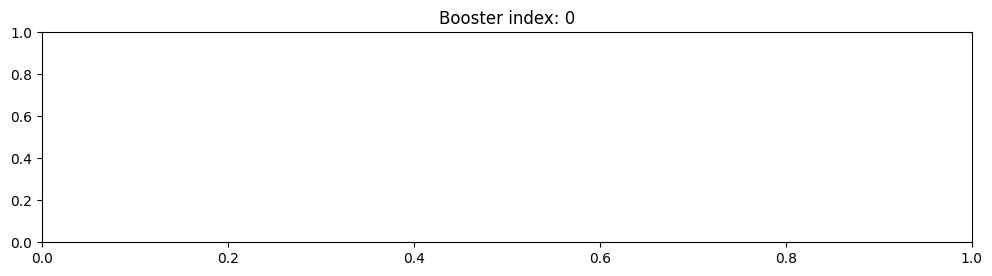

In [25]:
import matplotlib.pyplot as plt
rows = 2
cols = 1
fig = plt.figure(figsize=(12, 6))
for i in range(rows * cols):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(f'Booster index: {i}')
    lgb.plot_tree(booster=models[0],
                    tree_index=i,
                    show_info='internal_value',
                    ax=ax,
                    )
plt.show()